###### Tomé SADONES & Florent TACHENNE
# TP 3 : Steganography and Image indexing
---
## Part 1 : Steganography

Le but de cette partie sera de cacher au sein d'une image codée sur **8 bits** deux images, une support qui va utiliser les **4 premiers bits** dit de *poids fort* et une cachée qui utilisera les **4 derniers bits**, dit de *poids faible*.

Autrement dit, on prendra l'image Support, dont l'écriture binaire est de la sorte : **'`ABCD` EFGH'**. On supprime les bits de poids faible grâce à l'instruction binaire **&**, pour obtenir : **'`ABCD` 0000'**.

Ensuite, on fait le même traitement avec l'image à chacher, **'`HIJK` LMNO'** -> **'`HIJK` 0000'**. Puis on décale tous les *bits de poids forts* vers les *bits de poids faible* : **'`HIJK` 0000'** -> **'0000 `HIJK`'**. 

On peut finalement additioner les deux images, la *Support* et la *Hidden* pour obtenir les entiers suivant en binaire : **'`ABCD` `HIJK`'**. 

En définitive, nous avons diminué l'échantillonnage de l'image *Hidden*, passant de **8 bits** à **4 bits**, que nous avons ensuite inséré dans l'image *Support*. L'image *Support* également est modifié, mais avec un traitement différent de l'image *Hidden*, dont les répercussions seront étudiées plus tard.


*N.B : Dans toute cette partie, les lettres majuscules en gras "**A**" représentent un bit, et peuvent donc prendre la valeur **0** ou **1**.* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage.color as skic
from skimage import img_as_ubyte
import time as time
import skimage.transform as skit
import skimage.exposure as skie

# 1 : Image encoding
## Tests des opérateurs binaires

Afin d'effectuer les opérations précedentes, il nous faut prendre en main les **opérateurs binaires** de python

Nous auront seulement besoin dans ce TP de :

 ### - **&** : l'opérateur de comparaison binaire

Celui ci nous permet de comparer un à un les bits de deux entiers :

A = 10011 *(binaire)* <-> 19 *(décimal)* 

B = 01010 *(binaire)* <-> 10 *(decimal)* 

Résultat : A **&** B = 00010 *(binaire)* <-> 2 *(décimal)*

 ### - **>>** : l'opérateur de décalage binaire

Celui ci nous permet de décaler vers la droite *(**<<** vers la gauche)* tous les bits d'un entier *(correspond à une multiplication/division par deux)* :

A = 01000 *(binaire)* <-> 8 *(Décimal)*

Résulat : A **>>** 2 = 00010


In [2]:
# 'X>>n' ou 'X<<n' : Décalage de tous les bits vers la droite ou la gauche de X n fois.
# Equivalent à division ou multiplication par 2^n


a = 8
b = a >> 2
print("Test '>>' : Resultat attendu : 2, résultat obtenu : ", b)


# A = binaire : 10011 <-> decimal 19
# B = binaire : 1010 <-> decimal 10
# C = A&B binaire 1&0 -> 0, 0&1 -> 0, 0&0 -> 0, 1&1 -> 1, 1@0 -> 0 : bianire 00010 <-> decimal 2
A = 19
B = 10
C = A & B
print("Test '&' : Resultat attendu : 2, résultat obtenu : ", C)

Test '>>' : Resultat attendu : 2, résultat obtenu :  2
Test '&' : Resultat attendu : 2, résultat obtenu :  2


# 1.1 : Image display

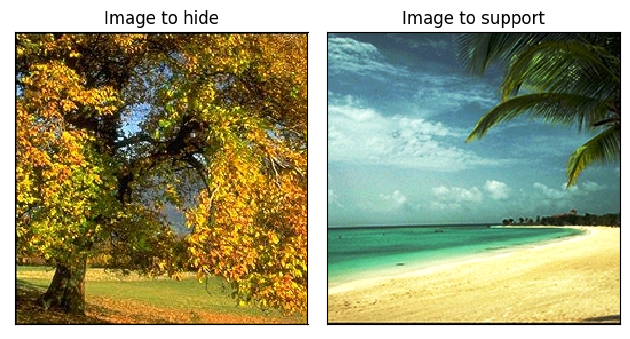

In [4]:
# Début TP

filepath_1 = "./img_to_hide.png"
filepath_2 = "./support_img.png"
Hide = skio.imread(filepath_1)
Support = skio.imread(filepath_2)


plt.figure(1)

plt.subplot(121)  # Affichage de l'image à cacher
plt.xticks([])
plt.yticks([])
plt.title("Image to hide")
skio.imshow(Hide)

plt.subplot(122)  # Affichage de l'image support
plt.xticks([])
plt.yticks([])
plt.title("Image to support")
skio.imshow(Support)

# 1.2 : Mise en place des opérateurs binaires


Il nous faut désormais créer 2 fonctions : ***suppress_bits()*** et ***suppress_and_shift_bits()***. Grâce aux opérateurs binaires précédents et au nombre **240** *(**111000** en binaire)*, ces deux fonctions nous permettrons de transformer les pixels de l'image *Support* : ***'ABCD EFGH' -> 'ABCD 0000'*** et aussi de transformer les pixels de l'image *Hidden* : **'HIJK LMNO' -> '0000 HIJK'**

In [5]:
def suppres_and_shift_bits(image):
    return np.array([[[(color & 240) >> 4 for color in column] for column in lines] for lines in image], dtype='uint8')


def suppres_bits(image):
    return np.array([[[(color & 240) for color in column] for column in lines] for lines in image], dtype='uint8')


processed_hidden = suppres_and_shift_bits(Hide)
processed_support = suppres_bits(Support)

# Effet de la suppression des bits

Affiché précedemment sont les deux images *Support*, la première est l'originelle, la seconde n'a pas ses **bits de poids faible**. Autrement dit, nous avons réduit l'échantillonnage de l'image *Support*. Les valeurs de ses pixels n'est plus dans [0 ; 256], mais dans [0, 15, 30, ..., 225, 240] tous les entiers n < 255 tels que n = (16-1)*i, i un entier. 

L'image présentera donc moins de couleurs : au lieu des 256\*256\*256 ~ **16 millions** habituels, nous n'auront ici que 16\*16\*16 = **4 096** couleurs, ce qui est une représentation trop faible du spectre des couleurs visibles pour notre œil. Il sera donc capable de voir les distinctions.

Effectivement, en regardant attentivement le ciel de l'image de droite, on distingue des sauts de couleurs, allant du blanc des nuages au bleu du ciel.

Les images sont identiques :  False


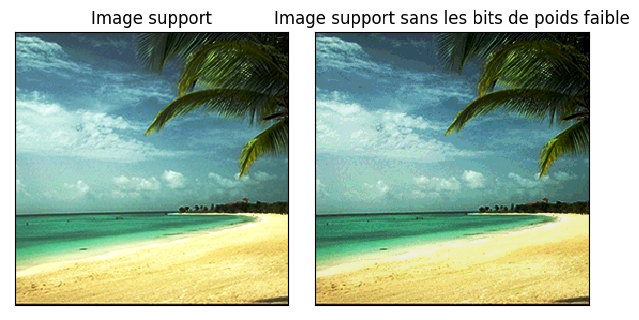

In [6]:

# filename = "processed_image.png"  # Le nom du fichier enregistré
#plt.imsave(filename, processed_image)
plt.figure(1)
plt.subplot(122)
skio.imshow(processed_support)
plt.xticks([])
plt.yticks([])
plt.title("Image support sans les bits de poids faible")
plt.subplot(121)
skio.imshow(Support)
plt.xticks([])
plt.yticks([])
plt.title("Image support")
print("Les images sont identiques : ", np.allclose(processed_support, Support))

# 1.3 : Effet du shifting des bits

La figure précedente montre l'image *Hidden* originelle, puis après l'application de ***suppress_and_shift_bits()***. Il faut monter la luminosité de son écran pour voir les détails de la première image dans la seconde. En affichant l'histogramme, on comprend bien qu'il y a eu le même traitement que précedemment, un echantillonnage des couleurs, puis que ces dernières ont été comprimées de l'espace [0, 15, 30, ... 240] vers [0;15]. 

On rappelle que 0, 15, 30 ... sont les entiers dont l'écriture binaire est de la forme **`ABCD 0000`**. En decalant leurs **bits** de 4 vers la droite, on obtient les entiers binaires **`ABCD`**, qui sont les entiers 0, ... 15.


Le traitement aura donc été un échantillonnage des couleurs puis une forte diminution de la luminosité de l'image *(**IMAGE >> 4 <=> IMAGE/16**)*, d'où l'image très sombre en sortie.

Un phénomène notable sur l'histogramme est cet espèce de zoom vertical, ou plutôt de diminution des maximums. Il est compréhensible que certaines valeurs d'intensité de pixels soient sur-représentées *(0 pour le bleu, puisque les tons sont principalement orange)*. Toutefois, en diminuant le nombre de **bits**, on comprime l'histogramme et les grandes valeurs rares sont moins exubérantes, puisque les autres valeurs d'intensité ont vu leur nombre de pixel augmenter par l'échantillonnage. On a donc des courbes avec des gradients plus homogènes.

Text(0.5, 1.0, 'Histogramme')

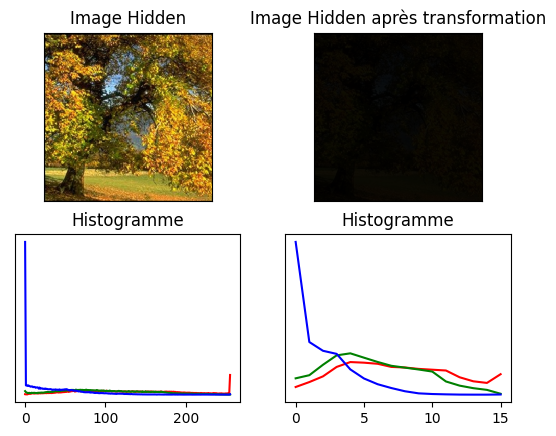

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(Hide)
plt.xticks([])
plt.yticks([])
plt.title("Image Hidden")
plt.subplot(222)
plt.imshow(processed_hidden)
plt.xticks([])
plt.yticks([])
plt.title("Image Hidden après transformation")
plt.subplot(223)
y_rouge, x = skie.histogram(Hide[:, :, 0])
y_vert, x = skie.histogram(Hide[:, :, 1])
y_bleu, x = skie.histogram(Hide[:, :, 2])
plt.plot(x, y_rouge, 'red')
plt.plot(x, y_vert, 'green')
plt.plot(x, y_bleu, 'blue')
plt.yticks([])
plt.title("Histogramme")
plt.subplot(224)
y_rouge, x = skie.histogram(processed_hidden[:, :, 0])
y_vert, x = skie.histogram(processed_hidden[:, :, 1])
y_bleu, x = skie.histogram(processed_hidden[:, :, 2])
plt.plot(x, y_rouge, 'red')
plt.plot(x, y_vert, 'green')
plt.plot(x, y_bleu, 'blue')
plt.yticks([])
plt.title("Histogramme")


# 1.4 : Création de l'image finale

Maintenant que nous avons nos deux images *Support* et *Hidden* prêtes, il suffit de les additionner pour obtenir l'image finale *(l'addition en binaire fonctionne de la même manière qu'en décimal)*

| Puissance de 2 | 7 | 6 | 5 | 4 | 3 | 2 | 1 | 0 |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| *Support* | `A` | `B` | `C` | `D` | **0** | **0** | **0** | **0** |
| *Hidden* | **0** | **0** | **0** | **0** | `H` | `I` | `J` | `K` |
| *Somme* | `A` | `B` | `C` | `D` | `H` | `I` | `J` | `K` |

Ensuite, nous utilisons la méthode ***np.allclose()*** pour comparer les deux images.

Les images sont identiques :  True


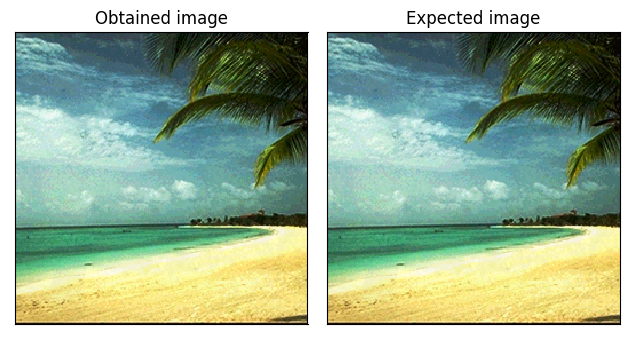

In [8]:
expected_processed_image = skio.imread("./mixed_img_result.png")
processed_image = processed_hidden + processed_support

plt.figure(1)

plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title("Obtained image")
skio.imshow(processed_image)

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.title("Expected image")
skio.imshow(expected_processed_image)

print("Les images sont identiques : ", np.allclose(
    processed_image, expected_processed_image))

# 1.5 : Création de notre propre image

On applique sur deux images de notre choix les opérations précedentes, et on enregistre l'image ainsi créée en format *.png*. 
A noter qu'il faut convertir nos images *.jpg* avec ***skimage.img_as_ubytes***.

Puisque nos deux images sont de dimensions différentes, on les resize pour pouvoir cacher l'une dans l'autre.
On remarque bien l'absence des bits faible de l'image "mountain" dans l'image "lion hidden in mountain" si l'on regarde le ciel qui n'est plus dégradé et comporte à la place des zones de couleurs distinctes. 

152


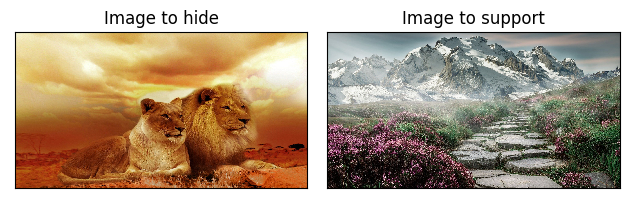

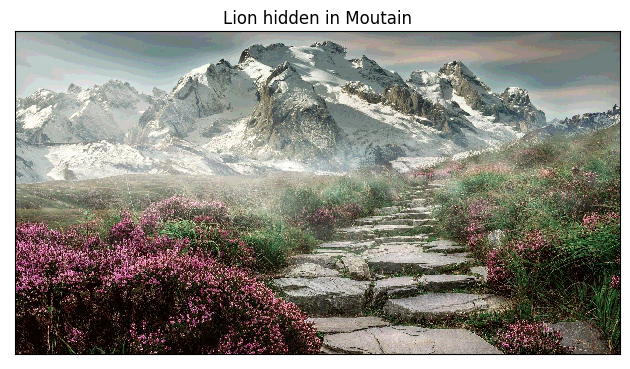

In [9]:
Lion = skio.imread("./lions.jpg")
Mountain = skio.imread("./mountain.jpg")

Lion = img_as_ubyte(skit.resize(Lion, Mountain.shape))
Mountain = img_as_ubyte(Mountain)
print(Mountain[0, 0, 0])


plt.figure(1)

plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title("Image to hide")
skio.imshow(Lion)

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.title("Image to support")
skio.imshow(Mountain)
Lion_hidden = suppres_and_shift_bits(Lion)

Mountain_support = suppres_bits(Mountain)
Lion_Mountain = Lion_hidden + Mountain_support
plt.figure(2)
plt.title("Lion hidden in Moutain")
plt.xticks([])
plt.yticks([])
skio.imshow(Lion_Mountain)

plt.imsave("SADONES_TACHENNE_mixed_image.png", Lion_Mountain)


# To be delivered


On implemente les deux fonctions ***SADONES_TACHENNE_encoder(Support, Hidden)*** ***SADONES_TACHENNE_decoder(Image)*** qui vont respectivement :

- Cacher l'image *Hidden* dans l'image *Support*
- Récuperer l'image *Hidden* dans l'image *Hidden*


In [10]:
def SADONES_TACHENNE_encoder(Support, Hidden):
    """
    Fonction qui va cacher par la méthode de Steganography l'image support dans l'image Hidden.
    Attention, les deux images doivent être codées sur 8 bits.
    Input :
        - Support (np.ndarray) : Image (rgb ou gray) support de l'image à cacher
        - Hidden (np.ndarray) : Image (rgb ou gray) à cacher dans support
    Output : 
        - Image (np.ndarray) : Image (rgb ou gray) qui contient l'image Hidden dans l'image Support
    """
    Processed_Hidden = suppres_and_shift_bits(Hidden)
    Processed_Support = suppres_bits(Support)
    return Processed_Hidden+Processed_Support


def SADONES_TACHENNE_decoder(Image):
    """
    Fonction qui va récuperer l'image Hidden dans Image
    Input :
        - Image (np.ndarray) : Image (rgb ou gray) support de l'image cachée
    Output : 
        - Hidden (np.ndarray) : Image (rgb ou gray) qui était cachée dans Image
    """
    return np.array(
        [[[(color & 15) << 4 for color in column]for column in lines]for lines in Image], dtype='uint8')


# 2.1 : Decodage 

Afin de récuperer l'image *Hidden* au sein de *Support*, il suffit d'appliquer la méthode inverse : 

On récupère les **4 bits de poids faible**, que l'on décale pour qu'ils deviennent les **4 bits de poids fort**.

*Support* : **'ABCD `HIJK`' -> '`HIJK` 0000'** *Hidden*.

On utilise donc *Support* **&** **15** **<<** **4**. *(C.f. fonction **SADONES_TACHENNE_decoder()**)*


## Récupération de notre image

On récupère donc notre image avec la fonction **SADONES_TACHENNE_decoder()**. Puis on affiche son histogramme sur les 3 couleurs, et on le compare avec celui de l'image de base. 

On arrive à récuperer l'image cachée, mais de la même manière que pour *Support*, on récupère l'image échantillonnée. Ce phénomène se voit particulièrement sur l'histogramme de notre image de base.

On affiche également la valeur max de l'image récuperée. On obtient 240 au mieux. Ceci est dû au fait que le maximum de l'image est **'``1111`` 0000'** après décodage, qui correspond à la valeur 240 en décimal.

Le maximum de l'image récupérée est :  240  , résultat attendu X ≤ 240


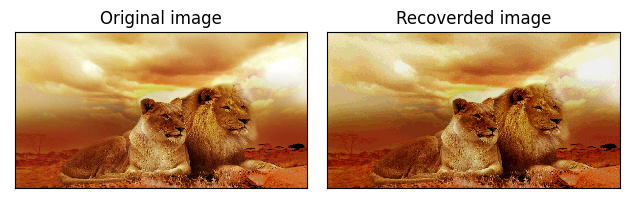

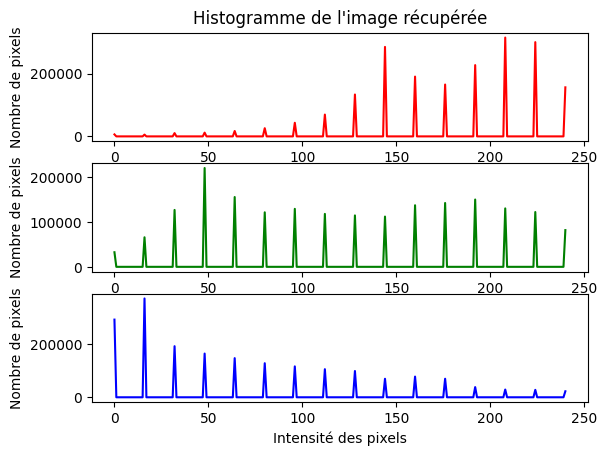

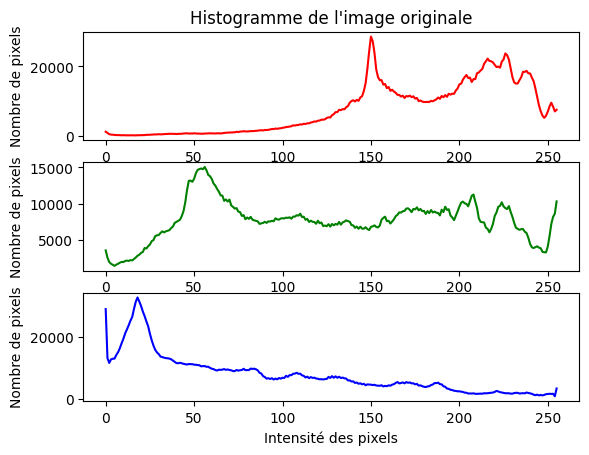

In [11]:
plt.figure(1)

plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title("Original image")
skio.imshow(Lion)
recovered_Lion = SADONES_TACHENNE_decoder(Lion_Mountain)
plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.title("Recoverded image")
skio.imshow(recovered_Lion)

np.allclose(Lion, recovered_Lion)

plt.figure(2)


y_rouge, x = skie.histogram(recovered_Lion[:, :, 0])
y_vert, x = skie.histogram(recovered_Lion[:, :, 1])
y_bleu, x = skie.histogram(recovered_Lion[:, :, 2])
plt.subplot(311)
plt.title("Histogramme de l'image récupérée")
plt.plot(x, y_rouge, 'red')
plt.ylabel("Nombre de pixels")
plt.subplot(312)
plt.plot(x, y_vert, 'green')
plt.ylabel("Nombre de pixels")
plt.subplot(313)
plt.plot(x, y_bleu, 'blue')
plt.xlabel("Intensité des pixels")
plt.ylabel("Nombre de pixels")


plt.figure(3)


y_rouge, x = skie.histogram(Lion[:, :, 0])
y_vert, x = skie.histogram(Lion[:, :, 1])
y_bleu, x = skie.histogram(Lion[:, :, 2])
plt.subplot(311)
plt.title("Histogramme de l'image originale")
plt.plot(x, y_rouge, 'red')
plt.ylabel("Nombre de pixels")
plt.subplot(312)
plt.plot(x, y_vert, 'green')
plt.ylabel("Nombre de pixels")
plt.subplot(313)
plt.plot(x, y_bleu, 'blue')
plt.xlabel("Intensité des pixels")
plt.ylabel("Nombre de pixels")


print("Le maximum de l'image récupérée est : ", np.max(
    recovered_Lion), " , résultat attendu X ≤ 240")

# Décodage des images fournies

On récupère les images fournies **mixed_img1.png** et  **mixed_img2.png**, que l'on décode avec notre fonction ***SADONES_TACHENNE_decoder()***. On affiche les résultats dans un subplot.

Tout d'abord, notre méthode fonctionne parfaitement et nous sommes capable de récuperer l'information cachée.

Un phénomène notable que nous avons évité jusqu'à présent est l'influence de l'image *Hiden* dans l'image *Support*. Des reliquats sont effectivement visibles dans **mixed_img2.png**, il nous semble voir apparaître certains contours épais de l'image avec le père noël. 

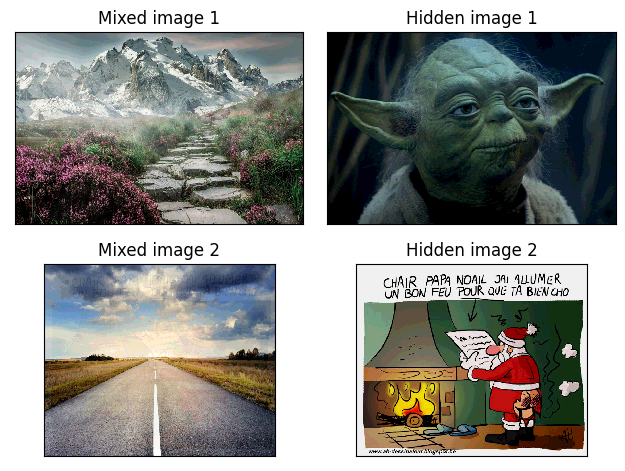

In [12]:
mixed_image1 = skio.imread("./mixed_img1.png")
mixed_image2 = skio.imread("./mixed_img2.png")

plt.figure(1)

plt.subplot(2, 2, 1)
plt.title("Mixed image 1")
plt.xticks([])
plt.yticks([])
skio.imshow(mixed_image1)

plt.subplot(2, 2, 2)
plt.title("Hidden image 1")
plt.xticks([])
plt.yticks([])
skio.imshow(SADONES_TACHENNE_decoder(mixed_image1))

plt.subplot(2, 2, 3)
plt.title("Mixed image 2")
plt.xticks([])
plt.yticks([])
skio.imshow(mixed_image2)

plt.subplot(2, 2, 4)
plt.title("Hidden image 2")
plt.xticks([])
plt.yticks([])
skio.imshow(SADONES_TACHENNE_decoder(mixed_image2))


# Influence de l'image *Hiden* sur l'image *Support*

Comme vu précedemment avec le père Noël, certains reliquats peuvent apparaître sur l'image *Support* une fois qu'elle contient l'image *Hidden*. Ceci se produit quand l'influence des **bits de poids faible** n'est pas négligeable face à ceux de **poids fort**. Deux cas de figure sont possibles :

- Une image *Support* sombre contre une image *Hidden* lumineuse. Dans ce cas, comme ci-dessous, on peut voir apparaître l'image *Hidden*, assombrie, dans l'image reconstruite. Les **bits de poids forts** étant de l'ordre des **bits de poids faible** *(**0000 0000** vs **0000 1111**)*, ce sont ces derniers qui priment. Or, ils représentent l'image *Hidden*, qui réapparaît.

- Un fort gradient dans l'image *Hidden* *(**0000 0000** puis **0000 1111** sur des pixels voisins)* dans une zone de faible gradient dans l'image *Support*. Alors, l'image *Hidden* causera un saut d'intensité de 6% dans le cas d'une zone blanche *(le ciel au dessus de la route)* pour les démarcations du dessin *(zones noires et blanches de la liste ou du bonnet)*

*NB : Un œil averti distinguera la perte de luminosité dans l'image reconstruite des 9 couleurs dans l'exemple. C'est l'effet de la limite à 240 dont nous avons parlé précedemment*

c:\Users\flore\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


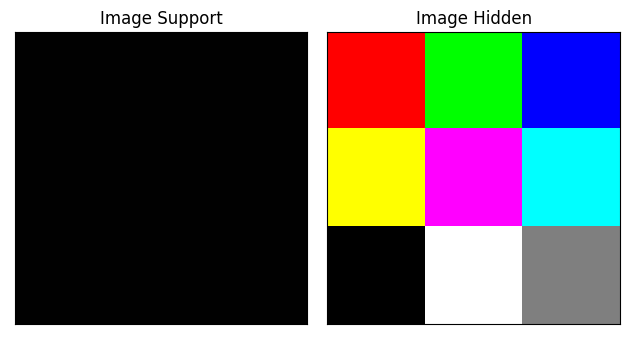

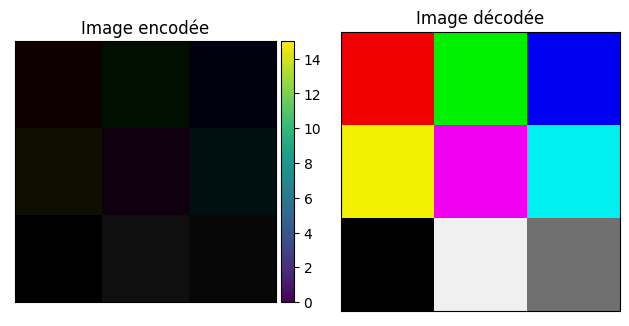

In [13]:
image_hidden_test = np.array(([[255, 0, 0], [0, 255, 0], [0, 0, 255]], [[255, 255, 0], [
                             255, 0, 255], [0, 255, 255]], [[0, 0, 0], [255, 255, 255], [127, 127, 127]]), dtype='uint8')
image_support_test = np.ones((3, 3, 3), dtype='uint8')
plt.figure(1)
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title("Image Support")
skio.imshow(image_support_test)

plt.subplot(122)
plt.xticks([])
plt.yticks([])
skio.imshow(image_hidden_test)
plt.title("Image Hidden")

encoded_test = SADONES_TACHENNE_encoder(image_support_test, image_hidden_test)
decoded_test = SADONES_TACHENNE_decoder(encoded_test)
plt.figure(2)
plt.subplot(121)
plt.xticks([])
plt.yticks([])
plt.title("Image encodée")
skio.imshow(encoded_test)

plt.subplot(122)
plt.xticks([])
plt.yticks([])
plt.title("Image décodée")
skio.imshow(decoded_test)